# Dogs vs Cats - Image classification notebook made by Øystein Knudsen

### The notebooks structure

Given a large dataset of 25 000 photos (50/50 cats and dogs) I will
build and train a convolutional neural network to be able to classify the
new images correctly. I will be following the 8 step "Machine Learning Project Checklist" 
taken from the book "Hands on Machine Learning with Scikit Learn and TensorFlow" quite closely. 

 1. Frame the problem and look at the bigger picture.
 2. Get the data.
 3. Explore the data to gain insights.
 4. Prepeare the data to better expose the underlying data patterns to Machine Learning algorithms.
 5. Explore many different models and short-list the best ones.
 6. Fine-tune your models and combine them into a great solution.
 7. Present your solution.
 8. Launch, monitor and maintain your system. 
 

## Step 1: Framing the problem and looking at the bigger picture

### The task at hand 

The goal of this notebook is to create a model which is able to
classify an image to be either a dog or a cat.

(read more at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

### The tools 

In [1]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import keras as ks
import cv2
import random
import numpy as np
from random import shuffle #shuffling the data
from sklearn.model_selection import train_test_split
import time


Using TensorFlow backend.


#### Keras
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

In my case I will be using Keras with a Tensorflow back-end. 

#### Tensorflow

Taken from tensorflow.org:

"TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains."

#### tqdm 
Simply just a tool for showing cool progress bars. It's nice to know the progress when working on big data sets.

#### NumPy

NumPy is the fundamental package for scientific computing with Python. It contains among other things:

- a powerful N-dimensional array object
- sophisticated (broadcasting) functions
- useful linear algebra, Fourier transform, and random number capabilities

Besides its obvious scientific uses, NumPy can also be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined. This allows NumPy to seamlessly and speedily integrate with a wide variety of databases.

#### Matplotlib.pyplot

pyplot is used for plotting data. e.g., create a figure, create plotting area in a figure, plot some lines in a plotting area, decorate the plot with labels, etc.
#### TODO: Fill inn as you go

## Step 2: Getting the data

As mentioned the dataset is supplied in the Kaggle challenge. The dataset consists of 2 parts: 

Training set: 12500 pictures of dogs + 12500 pictures of cats. 
Test set: 12500 mixed pictures of dogs and cats.

The training set got the convenient naming convention of: "animal.number.jpg" For example: "cat.104.jpg" or "dog.0.jpg" which makes it an easy job to extract the label. 



    
    





#### Downloading the data from kaggle 

Using the Kaggle API I can easily download the images automatically with code. 

In [2]:
from pathlib import Path

In [3]:
#Creating the directory
NOTEBOOK_DIR = %pwd
NOTEBOOK_DIR = Path(NOTEBOOK_DIR)

DATA = NOTEBOOK_DIR/'data'
DATA.mkdir(exist_ok=True)


In [4]:
#Running the kaggle API using a subprocess
import subprocess

In [5]:
dataset_download_command = f'kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p {DATA}'

In [6]:
#subprocess.call(dataset_download_command, shell = True) #Uncomment to download data 

The data I downloaded consists of two zipped directories, the train and test data. 
In order to use this data I need to unzip it. This can be done with zipfile. 

In [7]:
import zipfile

In [8]:
#with zipfile.ZipFile(DATA/'test.zip',"r") as zip_ref: #unzipping the test data
#   zip_ref.extractall(DATA) #uncomment to unzip data 

In [9]:
# with zipfile.ZipFile(DATA/'train.zip',"r") as zip_ref: #unzipping the train data
#    zip_ref.extractall(DATA) #uncomment to unzip data

#### Loading the data 

Now that the data is successfully downloaded and extracted, it's ready to be loaded into the notebook. The first step is to get the path of all the different images in the dataset.  

In [10]:
TRAINING_DIRECTORY = 'data/train/'
TEST_DIRECTORY = 'data/test/'

In [11]:
train_images = [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY)] # The full data set 
train_dogs =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'dog' in i] # only dogs
train_cats =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'cat' in i] # only cats
test_images =  [TEST_DIRECTORY+i for i in os.listdir(TEST_DIRECTORY)] # Test images used for final validation of the model

In [12]:
def create_data_set(number_of_images): 
    number_of_each = int(number_of_images/2)
    return train_dogs[0:number_of_each] + train_cats[0:number_of_each]

### A set of variables used for testing different parameters when fine tuneing the model

When later exploring different values and parameters used for improving the accuracy It's a convenient thing to have some variables defined in the same place. 

In [13]:
IMG_SIZE = 180
NUMBER_OF_IMAGES = 3000
BATCH_SIZE = 15
LEARNING_RATE = 0.001
EPOCHS = 5
MODEL_NAME = "Cats-vs-dogs-cnn-LR{}".format(int(time.time()))


When experimenting with different techniques for reaching my goal,

it might be useful to work with a smaller dataset than 25000 pictures. 

Creating a smaller data set to work with such that some tasks are not that time consuming.

In [14]:
train = create_data_set(NUMBER_OF_IMAGES)

## Step 3: Exploring the data to gain insights

### Looking at some of the pictures 



In [15]:
def readRandomImage():
    randomImage = cv2.imread(train[random.randint(1,len(train))]) #reading the file as an image 
    return randomImage

In [16]:
# Taken from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

def show_images(images, cols = 1, titles = None):
   
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image)
        a.set_title(title, fontsize= 30)
        
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [17]:
randomImages = []
for i in range (8): 
    randomImages.append(readRandomImage())

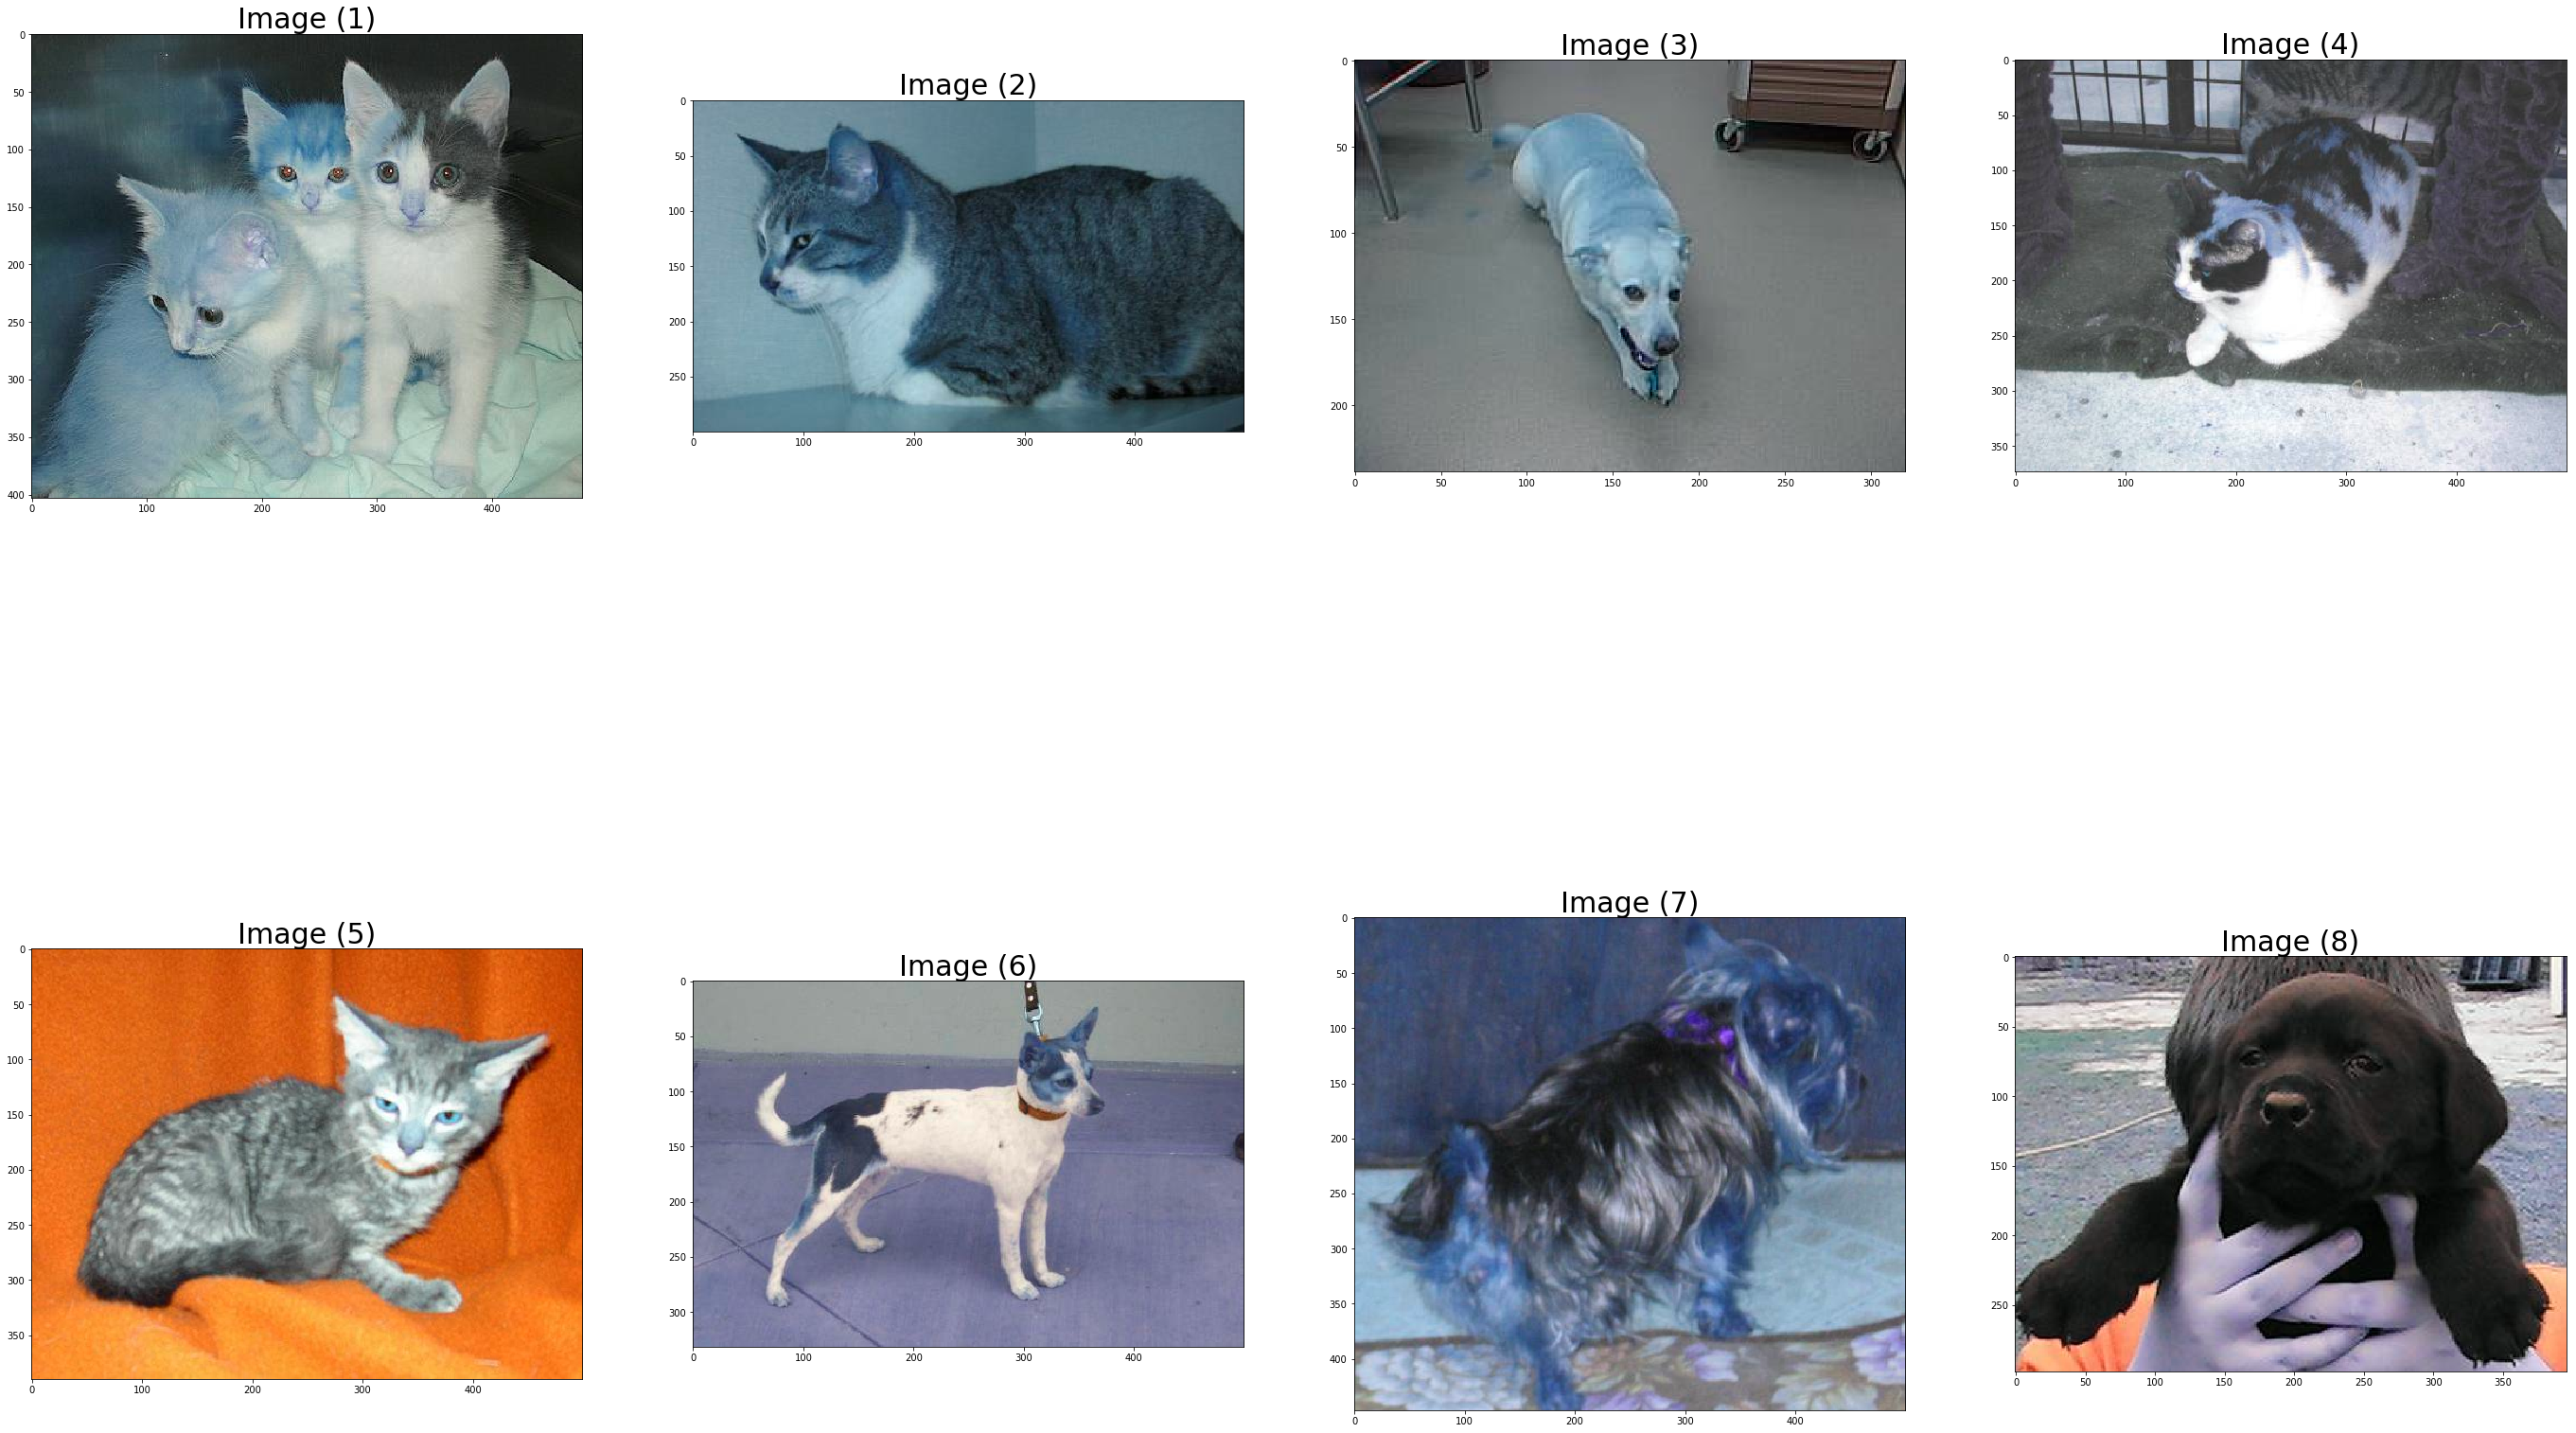

In [18]:
show_images(randomImages,2)

Looking at the random images taken from the training set, we can see that there is a variety of pictures. 
There are some close ups, some with multiple animals, some unclear and some with the owner included. However these things are all fine to feed as input to the ML-algorithm, it's the varying picture size that might be an "issue". 

## Step 4: Prepearing the data to better expose the underlying data patterns to ML-algorithms

#### Transforming the data set

Now that I have retrieved the data and looked at it, It's time to do the appropriate preperations. In order for me to feed this data into the ML-model, normalizing the data would be the best option. Meaning I will have to rezise all images into the same shape. 


Taking advantage of the naming convention we can easily extract the label from the path. Then convert it into a 
one-hot encoded value where [1,0] is a cat and [0,1] is a dog, as shown in the function below.

In [19]:
def extract_label(image):
    word_label = image.split('.')[-3] 
    final_label = word_label.split('/')[2] # Must be a better way to do this
    
    if final_label == 'cat' : return [1,0]
    
    elif final_label == 'dog' : return [0,1]

In [20]:
def one_hot_to_label(oneHot):
    if oneHot[0] == 1 : return 'cat'
    
    elif oneHot[0] == 0 : return 'dog'

The function below does several important proseccing steps to our data. 

Iterates through our training data and does the following: 
    1. extracts label. 
    2. reads the image from path into an array. 
    3. converts the image into grayscale, in order to reduce image size. 
    4. appends the image and it's label to the new training data list.
    
    Then 
     shuffles the data. 
     saves the data such that we can load it from file when tweaking the model. 

In [71]:
def create_training_data(train_data_set):
    training_data = [] 
    for img in tqdm(train_data_set): #tqdm for progress bar 
        label = extract_label(img) # extracts label from the path and returns it as one-hot array 
        img_array = cv2.imread(img, cv2.IMREAD_COLOR) # provides the img path and in which way to read the image 
        resized_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resizes the image to defined image size. 
        training_data.append([np.array(resized_img_array), np.array(label)]) #Appends the image and its label to the training data 
    shuffle(training_data) # After appending all images and labels I shuffle the data. 
    np.save('train_data.npy', training_data) # Saves the training data to disk for future use. 
    return training_data 
        

In [22]:
    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

In [23]:
train_data = create_training_data()
#train_data = np.load('train_data.npy') #USE THIS FOR LOADING THE DATA FROM FILE  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 501.37it/s]


In [24]:
def plot_image(image, onehot = None):
    if onehot.any: 
        print("This is a: " + one_hot_to_label(onehot))
    image_plot = plt.imshow(image)
    

In [25]:
def plot_image_by_index(index):
    instance = train_data[index]
    image = instance[0]
    onehot = instance[1]
    plot_image(image, onehot)

This is a: cat


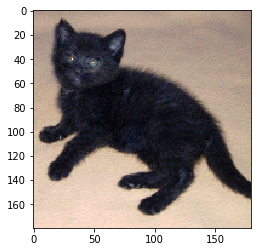

In [26]:
plot_image_by_index(2000)

#### Creating the test data 
I also need to create the test dataset which will be used to determine the models performance. 

In [27]:
def create_test_data(): 
    test_data = [] 
    for img in tqdm(test_images):
        without_filetype = img.split('.')[0]
        img_num = without_filetype.split('/')[1] #extract image number from path
        
        img = cv2.imread(img, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #resize image such that all images are the same size. 
        test_data.append([np.array(img), img_num]) 
    
    shuffle(test_data)
    np.save('test_data.npy', test_data) #Save to disk for future use 
    return test_data
         

In [28]:
#test_data = create_test_data()
test_data = np.load('test_data.npy') #Use this for loading file from disk 

####  A peek at the transformed data 

All images are now of size 90 x 90.

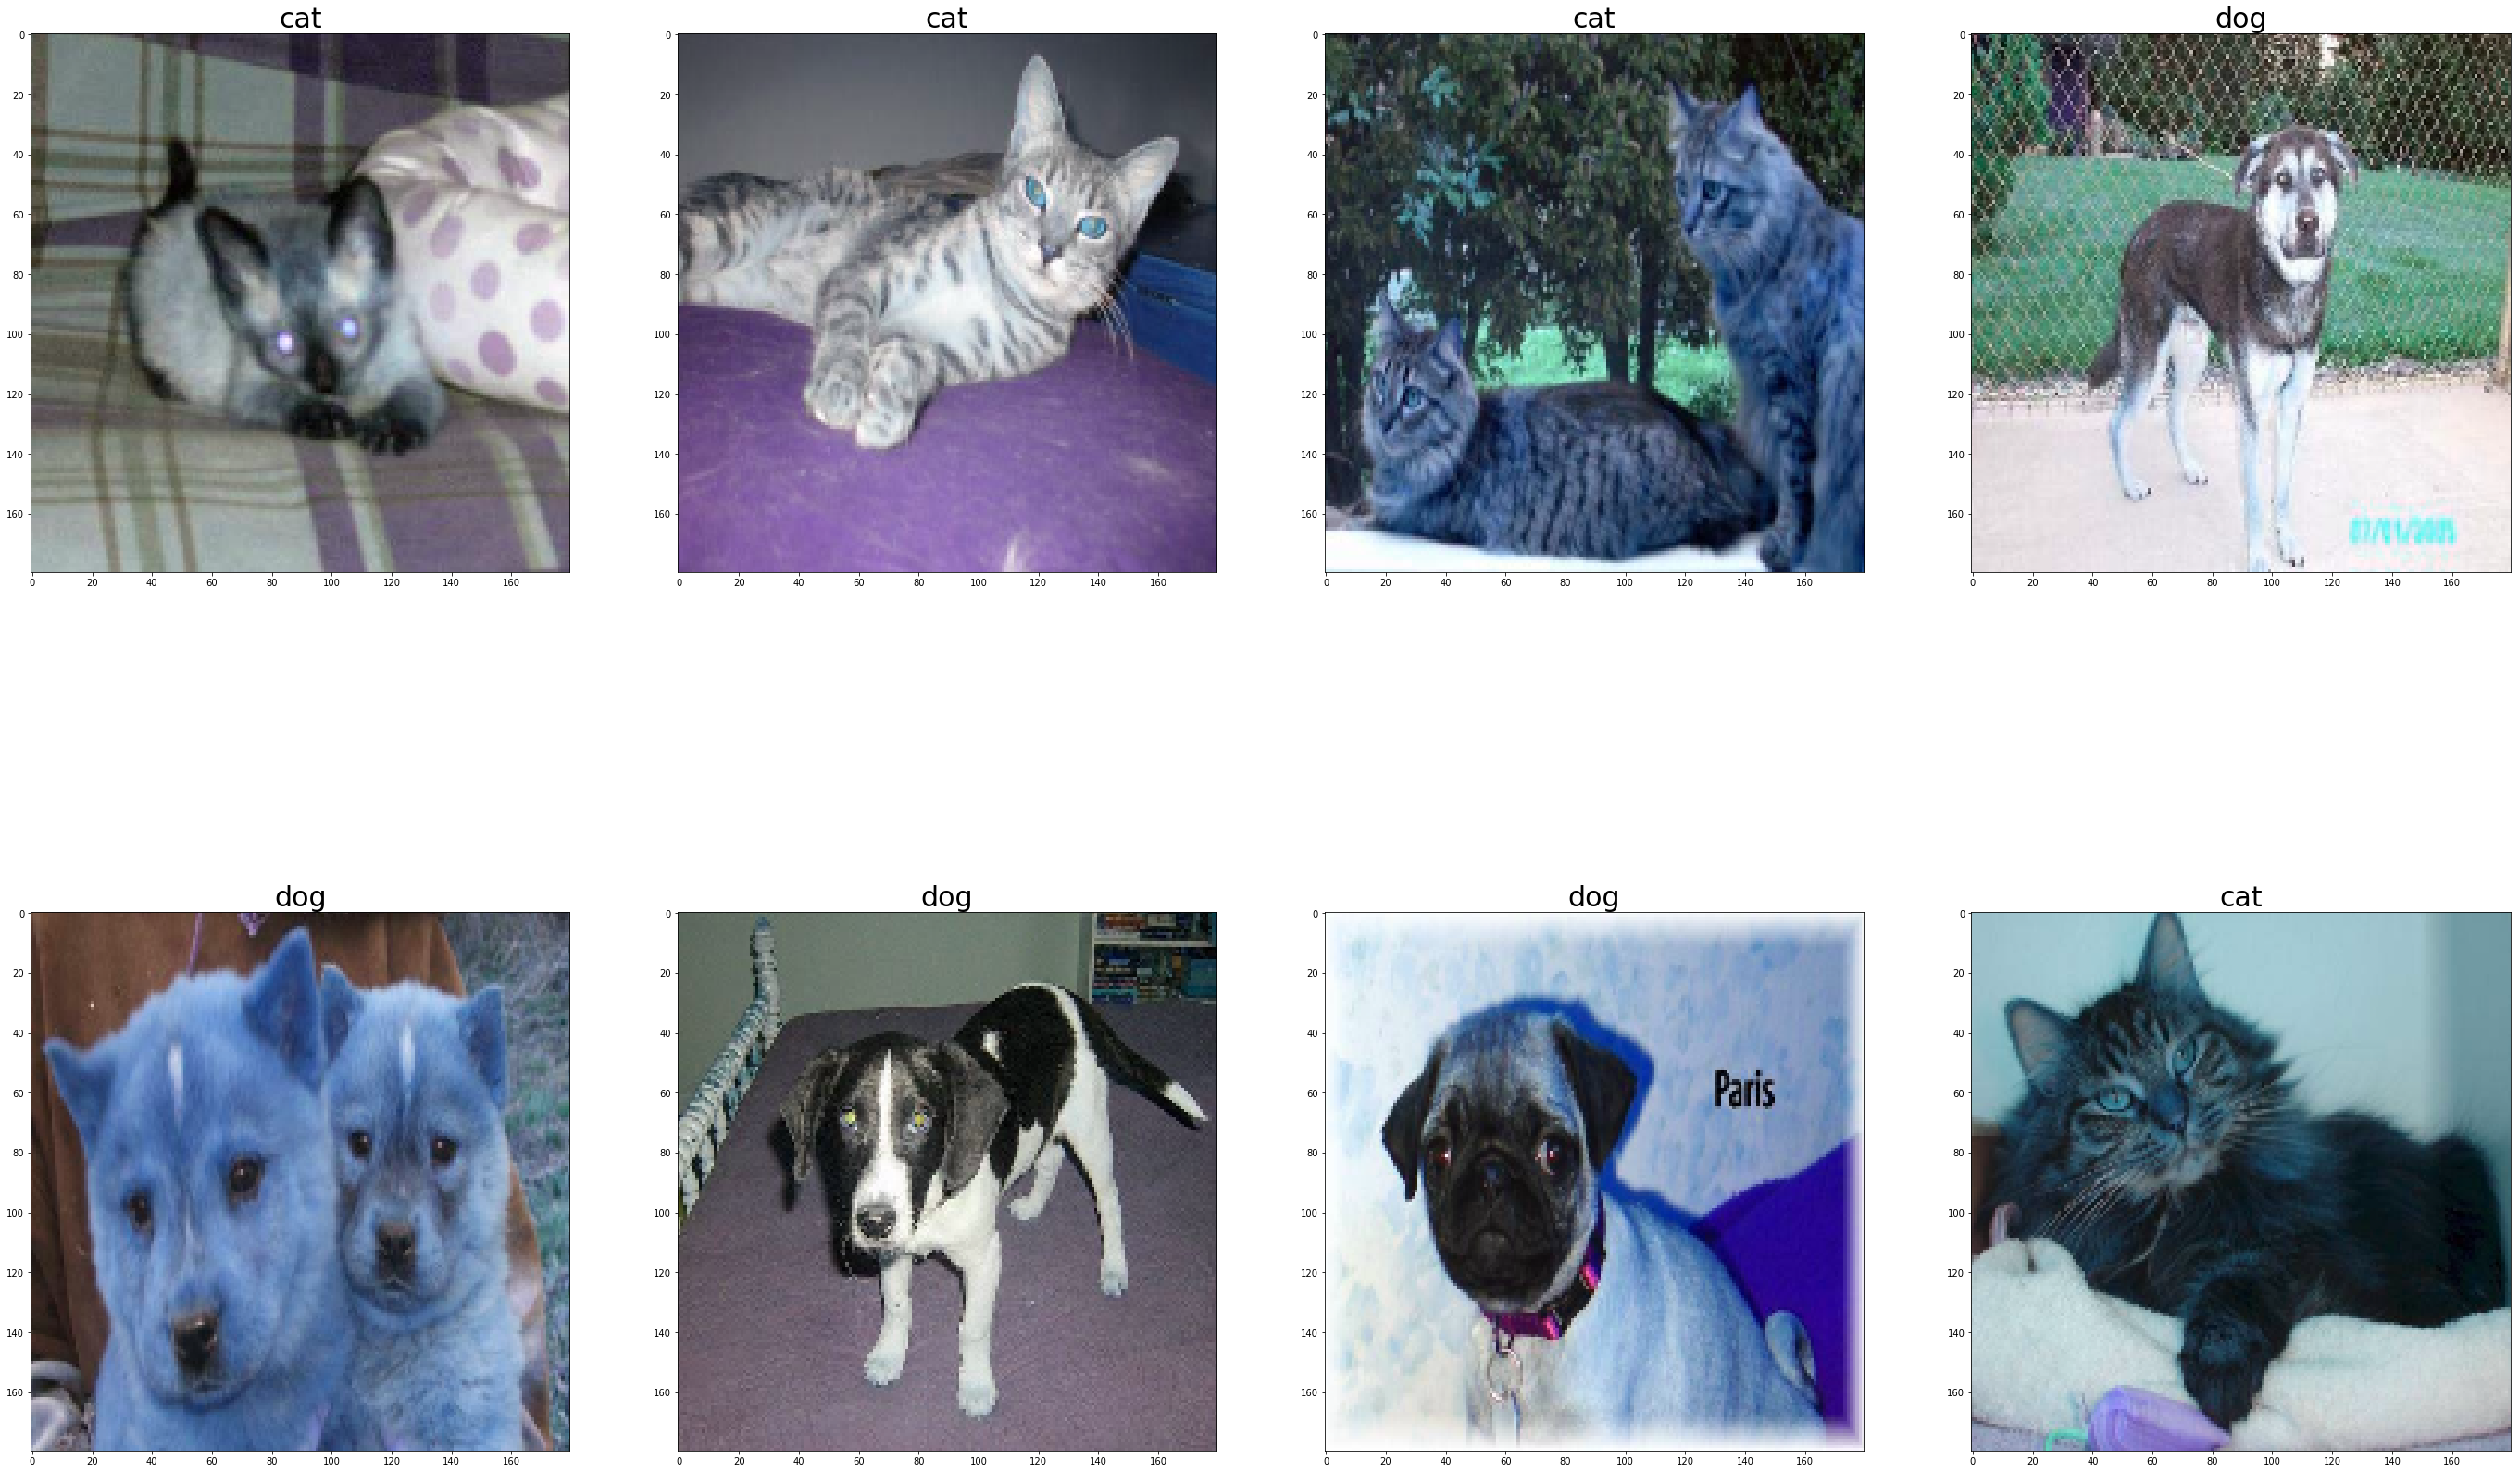

In [29]:
imagesToShow = []
titles = []
for i in range (8): 
    obj = train_data[i]
    titles.append(one_hot_to_label(obj[1]))
    img = obj[0]
    imagesToShow.append(img)
show_images(imagesToShow,2,titles)

#### seperating into features and labels 
When creating building my model I want to pass in my features as a NP-array and a label set (y). 
Therefore I need to split my current training dataset into two parts.

In [30]:
def seperate_features_and_labels(train_data):
    X = [] 
    y = []
    for features, label in train_data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) #Keras expects a nparray of this shape.
    y = np.array(y)
    return X, y

In [31]:
X, y = seperate_features_and_labels(train_data)

This is a: dog


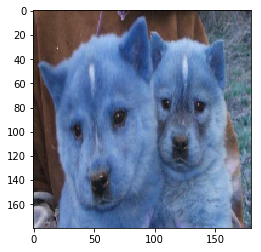

In [32]:
plot_image(X[4], y[4])

#### Splitting into training and validation sets 

In [33]:
# Normalize data - max value for pixel = 255
X = X/255.0 
 


In [34]:
print (X.shape)

(3000, 180, 180, 3)


In [35]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.15, random_state=42)

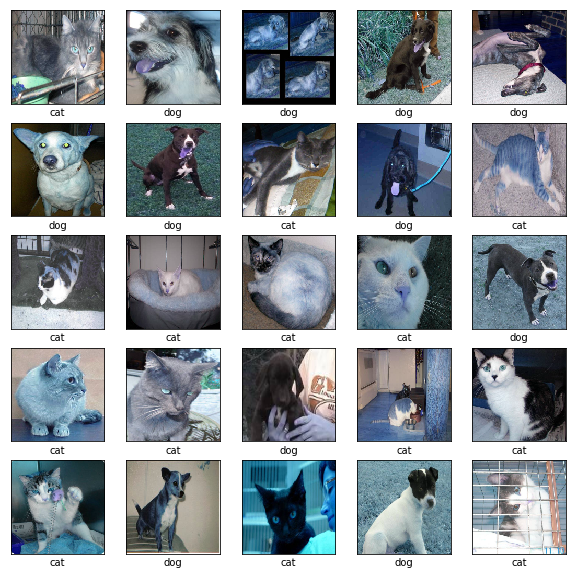

In [37]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(one_hot_to_label(y_train[i]))

## Step 5: Explore many different models and short-list the best ones. 

### The different types of models 
To solve this problem I have decided to use a Convolutional Neural Network in Keras, which is described earlier in the notebook. 
Keras has two built-in models available: sequential models and models created with the functional API. In addition to this you can also create custom models. 

#### The sequential model 

- The sequential model is a linear stack of layers. 
- Single input and single output.



#### The functional model 

- Enables you to define more complex models, such as multi-output models.
    




## Step 6: Fine-tuneing the models and combining them into a great solution

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop

### Bulding the model 

In [48]:
def create_model():
    optimizer = RMSprop(lr=LEARNING_RATE)
    objective = 'binary_crossentropy'
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (IMG_SIZE, IMG_SIZE,3))) # conv layer: units, window size and input shape
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))

    model.add(Dense(2)) # 
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics = ['accuracy'])


    return model

In [49]:

model = create_model()

#### Saving the model to tensorflow

In [41]:
from keras.callbacks import TensorBoard

In [42]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(MODEL_NAME))

In [43]:
history_model = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split = 0.25, callbacks=[tensorboard])

Train on 1912 samples, validate on 638 samples
Epoch 1/5
1912/1912 [==============================] - ETA: 9:02 - loss: 0.6946 - acc: 0.466 - ETA: 4:34 - loss: 1.4262 - acc: 0.483 - ETA: 3:13 - loss: 1.1820 - acc: 0.488 - ETA: 2:32 - loss: 1.0578 - acc: 0.516 - ETA: 2:06 - loss: 0.9711 - acc: 0.560 - ETA: 1:46 - loss: 0.9749 - acc: 0.555 - ETA: 1:31 - loss: 0.9363 - acc: 0.542 - ETA: 1:21 - loss: 0.9065 - acc: 0.516 - ETA: 1:12 - loss: 0.8820 - acc: 0.525 - ETA: 1:05 - loss: 0.8705 - acc: 0.506 - ETA: 1:00 - loss: 0.8538 - acc: 0.509 - ETA: 55s - loss: 0.8411 - acc: 0.505 - ETA: 51s - loss: 0.8308 - acc: 0.49 - ETA: 47s - loss: 0.8210 - acc: 0.49 - ETA: 44s - loss: 0.8120 - acc: 0.50 - ETA: 42s - loss: 0.8037 - acc: 0.51 - ETA: 40s - loss: 0.7968 - acc: 0.52 - ETA: 38s - loss: 0.7918 - acc: 0.52 - ETA: 37s - loss: 0.7873 - acc: 0.51 - ETA: 35s - loss: 0.7822 - acc: 0.51 - ETA: 34s - loss: 0.7796 - acc: 0.51 - ETA: 33s - loss: 0.7758 - acc: 0.51 - ETA: 31s - loss: 0.7720 - acc: 0.51 - E

1912/1912 [==============================] - ETA: 10s - loss: 0.6644 - acc: 0.60 - ETA: 10s - loss: 0.6694 - acc: 0.60 - ETA: 10s - loss: 0.6967 - acc: 0.48 - ETA: 10s - loss: 0.6920 - acc: 0.51 - ETA: 10s - loss: 0.6866 - acc: 0.57 - ETA: 10s - loss: 0.6904 - acc: 0.56 - ETA: 10s - loss: 0.6893 - acc: 0.56 - ETA: 10s - loss: 0.6832 - acc: 0.58 - ETA: 10s - loss: 0.6772 - acc: 0.59 - ETA: 12s - loss: 0.6702 - acc: 0.61 - ETA: 12s - loss: 0.6662 - acc: 0.61 - ETA: 13s - loss: 0.6642 - acc: 0.62 - ETA: 13s - loss: 0.7005 - acc: 0.60 - ETA: 13s - loss: 0.6991 - acc: 0.59 - ETA: 13s - loss: 0.6985 - acc: 0.59 - ETA: 13s - loss: 0.6992 - acc: 0.59 - ETA: 12s - loss: 0.6977 - acc: 0.58 - ETA: 12s - loss: 0.6961 - acc: 0.58 - ETA: 12s - loss: 0.6939 - acc: 0.58 - ETA: 11s - loss: 0.6911 - acc: 0.59 - ETA: 11s - loss: 0.6905 - acc: 0.59 - ETA: 11s - loss: 0.6904 - acc: 0.59 - ETA: 11s - loss: 0.6902 - acc: 0.59 - ETA: 11s - loss: 0.6893 - acc: 0.59 - ETA: 12s - loss: 0.6898 - acc: 0.58 - ETA: 

1912/1912 [==============================] - ETA: 11s - loss: 0.6045 - acc: 0.66 - ETA: 11s - loss: 0.5945 - acc: 0.66 - ETA: 11s - loss: 0.6026 - acc: 0.66 - ETA: 11s - loss: 0.6160 - acc: 0.64 - ETA: 13s - loss: 0.6332 - acc: 0.60 - ETA: 14s - loss: 0.6347 - acc: 0.60 - ETA: 14s - loss: 0.6469 - acc: 0.60 - ETA: 15s - loss: 0.6439 - acc: 0.61 - ETA: 15s - loss: 0.6377 - acc: 0.62 - ETA: 15s - loss: 0.6403 - acc: 0.62 - ETA: 14s - loss: 0.6428 - acc: 0.61 - ETA: 14s - loss: 0.6323 - acc: 0.63 - ETA: 13s - loss: 0.6431 - acc: 0.61 - ETA: 13s - loss: 0.6442 - acc: 0.60 - ETA: 12s - loss: 0.6466 - acc: 0.60 - ETA: 12s - loss: 0.6424 - acc: 0.61 - ETA: 12s - loss: 0.6458 - acc: 0.60 - ETA: 12s - loss: 0.6462 - acc: 0.60 - ETA: 12s - loss: 0.6404 - acc: 0.61 - ETA: 12s - loss: 0.6356 - acc: 0.61 - ETA: 12s - loss: 0.6333 - acc: 0.61 - ETA: 12s - loss: 0.6345 - acc: 0.61 - ETA: 12s - loss: 0.6335 - acc: 0.61 - ETA: 12s - loss: 0.6367 - acc: 0.60 - ETA: 12s - loss: 0.6349 - acc: 0.61 - ETA: 

1912/1912 [==============================] - ETA: 11s - loss: 0.5822 - acc: 0.73 - ETA: 11s - loss: 0.5663 - acc: 0.71 - ETA: 11s - loss: 0.5746 - acc: 0.66 - ETA: 11s - loss: 0.5692 - acc: 0.67 - ETA: 11s - loss: 0.5537 - acc: 0.68 - ETA: 11s - loss: 0.5554 - acc: 0.70 - ETA: 10s - loss: 0.5767 - acc: 0.68 - ETA: 10s - loss: 0.5728 - acc: 0.67 - ETA: 10s - loss: 0.5691 - acc: 0.69 - ETA: 13s - loss: 0.5582 - acc: 0.72 - ETA: 13s - loss: 0.5443 - acc: 0.73 - ETA: 12s - loss: 0.5393 - acc: 0.73 - ETA: 12s - loss: 0.5553 - acc: 0.73 - ETA: 12s - loss: 0.5580 - acc: 0.72 - ETA: 12s - loss: 0.5751 - acc: 0.72 - ETA: 11s - loss: 0.5719 - acc: 0.71 - ETA: 11s - loss: 0.5723 - acc: 0.71 - ETA: 11s - loss: 0.5777 - acc: 0.70 - ETA: 11s - loss: 0.5713 - acc: 0.70 - ETA: 10s - loss: 0.5699 - acc: 0.71 - ETA: 10s - loss: 0.5793 - acc: 0.70 - ETA: 10s - loss: 0.5762 - acc: 0.70 - ETA: 10s - loss: 0.5786 - acc: 0.69 - ETA: 10s - loss: 0.5727 - acc: 0.70 - ETA: 10s - loss: 0.5691 - acc: 0.70 - ETA: 

1912/1912 [==============================] - ETA: 10s - loss: 0.4906 - acc: 0.70 - ETA: 11s - loss: 0.5098 - acc: 0.66 - ETA: 11s - loss: 0.5274 - acc: 0.65 - ETA: 11s - loss: 0.5557 - acc: 0.65 - ETA: 11s - loss: 0.5271 - acc: 0.70 - ETA: 11s - loss: 0.5154 - acc: 0.73 - ETA: 11s - loss: 0.5096 - acc: 0.74 - ETA: 11s - loss: 0.5541 - acc: 0.71 - ETA: 11s - loss: 0.5638 - acc: 0.70 - ETA: 10s - loss: 0.5617 - acc: 0.70 - ETA: 10s - loss: 0.5514 - acc: 0.72 - ETA: 10s - loss: 0.5379 - acc: 0.73 - ETA: 10s - loss: 0.5201 - acc: 0.74 - ETA: 10s - loss: 0.5062 - acc: 0.75 - ETA: 10s - loss: 0.5294 - acc: 0.74 - ETA: 10s - loss: 0.5292 - acc: 0.74 - ETA: 10s - loss: 0.5315 - acc: 0.73 - ETA: 10s - loss: 0.5300 - acc: 0.74 - ETA: 10s - loss: 0.5295 - acc: 0.74 - ETA: 9s - loss: 0.5250 - acc: 0.7433 - ETA: 9s - loss: 0.5277 - acc: 0.736 - ETA: 9s - loss: 0.5245 - acc: 0.742 - ETA: 9s - loss: 0.5151 - acc: 0.746 - ETA: 9s - loss: 0.5080 - acc: 0.750 - ETA: 9s - loss: 0.5104 - acc: 0.752 - ETA:

In [46]:
def plot_history(history_model):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Convolutional Neural Network model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Convolutional Neural Network model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [65]:
IMG_SIZE = 180
NUMBER_OF_IMAGES = 5000
BATCH_SIZE = 20
LEARNING_RATE = 0.001
EPOCHS = 10

In [72]:
def do_cats_and_dogs():
    print("Creating data set with " + str(NUMBER_OF_IMAGES) + " images")
    train = create_data_set(NUMBER_OF_IMAGES)
    print ("Creating training data")
    train_data = create_training_data(train)
    print ("Creating test data")
    test_data = create_test_data()
    print ("Seperating features and labels")
    X, y = seperate_features_and_labels(train_data)
    print ("Normalizing data")
    X = X/255.0 #normalizing data
    print ("Splitting into training and validation set")
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=42)
    print ("Creating model")
    model = create_model()
    print ("Training model")
    history_model = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              validation_split = 0.25, callbacks=[tensorboard], verbose = 2)
    print ("Evaluating model on validation set")
    scores = model.evaluate(X_validation, y_validation)
    
    return history_model, scores
    
    
    
    

In [73]:
model, scores = do_cats_and_dogs()

Creating data set with 5000 images
Creating training data



 16%|████████████████████▊                                                                                                             | 802/5000 [00:05<00:27, 153.17it/s]


 33%|██████████████████████████████████████████                                                                                       | 1631/5000 [00:10<00:31, 106.34it/s]


 44%|████████████████████████████████████████████████████████▌                                                                        | 2190/5000 [00:15<00:25, 109.12it/s]


 56%|████████████████████████████████████████████████████████████████████████                                                         | 2795/5000 [00:20<00:16, 137.49it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 3357/5000 [00:26<00:13, 126.29it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4000/5000 [00:31<00:10, 95.19it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4540/5000 [00:36<00:04, 97.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 120.70it/s]

Creating test data



  4%|█████▋                                                                                                                            | 551/12500 [00:05<02:01, 97.97it/s]


  9%|████████████                                                                                                                    | 1177/12500 [00:10<01:25, 132.45it/s]


 15%|██████████████████▊                                                                                                             | 1833/12500 [00:15<01:18, 136.58it/s]


 20%|█████████████████████████                                                                                                       | 2451/12500 [00:20<01:28, 113.41it/s]


 24%|██████████████████████████████▋                                                                                                  | 2978/12500 [00:48<02:01, 78.26it/s]


 28%|████████████████████████████████████▎                                                                                           | 3546/12500 [00:53<01:15, 119.23it/s]


 33%|██████████████████████████████████████████▊                                                                                     | 4176/12500 [00:58<01:07, 122.70it/s]


 39%|█████████████████████████████████████████████████▉                                                                              | 4880/12500 [01:03<00:48, 158.05it/s]


 45%|█████████████████████████████████████████████████████████▌                                                                      | 5620/12500 [01:09<00:47, 143.79it/s]


 51%|████████████████████████████████████████████████████████████████▊                                                               | 6331/12500 [01:14<00:50, 123.25it/s]


 56%|███████████████████████████████████████████████████████████████████████▍                                                        | 6981/12500 [01:19<00:45, 120.59it/s]


 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 7717/12500 [01:24<00:36, 129.90it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 8462/12500 [01:29<00:26, 150.26it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 9192/12500 [01:35<00:24, 136.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 9835/12500 [01:40<00:22, 120.96it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 10478/12500 [01:45<00:15, 130.32it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 11010/12500 [01:50<00:19, 77.65it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 11539/12500 [01:56<00:08, 106.85it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 12050/12500 [02:01<00:05, 86.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [02:05<00:00, 99.49it/s]

Seperating features and labels
Normalizing data
Splitting into training and validation set
Creating model
Training model
Train on 3187 samples, validate on 1063 samples
Epoch 1/10
 - 20s - loss: 0.7117 - acc: 0.5529 - val_loss: 0.6828 - val_acc: 0.5626
Epoch 2/10
 - 24s - loss: 0.6312 - acc: 0.6494 - val_loss: 0.6364 - val_acc: 0.6275
Epoch 3/10
 - 24s - loss: 0.5870 - acc: 0.6978 - val_loss: 0.6261 - val_acc: 0.6524
Epoch 4/10
 - 23s - loss: 0.5352 - acc: 0.7369 - val_loss: 0.6619 - val_acc: 0.6468
Epoch 5/10
 - 22s - loss: 0.4960 - acc: 0.7664 - val_loss: 0.5707 - val_acc: 0.7187
Epoch 6/10
 - 21s - loss: 0.4408 - acc: 0.7975 - val_loss: 0.5628 - val_acc: 0.7357
Epoch 7/10
 - 22s - loss: 0.3861 - acc: 0.8298 - val_loss: 0.6504 - val_acc: 0.7375
Epoch 8/10
 - 21s - loss: 0.3352 - acc: 0.8536 - val_loss: 0.6290 - val_acc: 0.7324
Epoch 9/10
 - 21s - loss: 0.3019 - acc: 0.8695 - val_loss: 0.5277 - val_acc: 0.7606
Epoch 10/10
 - 23s - loss: 0.2423 - acc: 0.9001 - val_loss: 0.7227 - val_ac

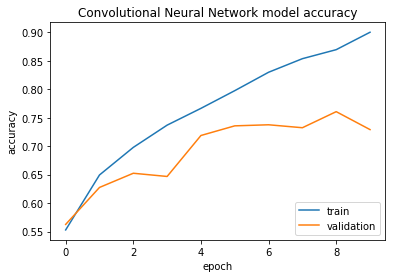

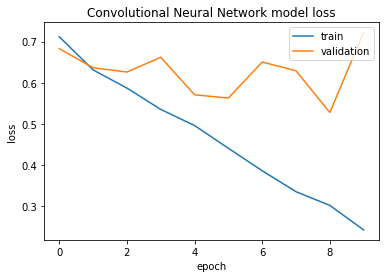

In [74]:
plot_history(model)

In [55]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

### Validation / performance measuring 

TODO: Cross validation
TODO: Confustion matrix
TODO: Boost???? 

## Step 7: Presenting the solution

## TODO

- Get the data using kaggle API and subroutine
- Combine CNN and XGBoost? 
- Cross validation 
- Confusion matrix 
- Plot bilde med label 
- Bruk funksjon te ittepå 

## Learning sources 

https://www.youtube.com/watch?v=YRhxdVk_sIs -- CNN's explained by deeplizard

https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL - Keras by deeplizard

https://medium.com/@parthvadhadiya424/hello-world-program-in-keras-with-cnn-dog-vs-cat-classification-efc6f0da3cc5 - Blogpost about using keras for image classification by parthvadhadiya424

https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter - Kaggle kernel for the dog-vs-cat competition by jeffd23

https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN - Deep Learning basics with Python, TensorFlow and Keras by sentdex

https://www.pugetsystems.com/labs/hpc/The-Best-Way-to-Install-TensorFlow-with-GPU-Support-on-Windows-10-Without-Installing-CUDA-1187/#vscode - Setup for environment 

https://www.kaggle.com/sentdex/full-classification-example-with-convnet - example notebook by sentdex

https://keras.io/getting-started/sequential-model-guide/ - The sequential model in Keras 

https://www.youtube.com/watch?v=VGCHcgmZu24 - The sequential model by Data Talks 

https://cran.rstudio.com/web/packages/keras/vignettes/about_keras_models.html - Keras models by The Comprehensive R Archive Network

https://www.youtube.com/watch?v=LhEMXbjGV_4 - Image preparation for CNN Image Classifier with Keras by deeplizard


https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning - Deep learning cheatsheet by Stanford CS229 

https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks - ML Practicum: CNN by Google 




